In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, jaccard_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer, StandardScaler

warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('../a. Datasets/EmployeeAttrition/Train_Dataset.csv')
test_data = pd.read_csv('../a. Datasets/EmployeeAttrition/Test_Dataset.csv')

In [3]:
train_data.head(2)

,EmployeeID,Attrition,Age,TravelProfile,Department,HomeToWork,EducationField,Gender,HourlnWeek,Involvement,...,JobSatisfaction,ESOPs,NumCompaniesWorked,OverTime,SalaryHikelastYear,WorkExperience,LastPromotion,CurrentProfile,MaritalStatus,MonthlyIncome
0,5110001.0,0.0,35.0,Rarely,Analytics,5.0,CA,Male,69.0,1.0,...,1.0,1.0,1.0,1.0,20.0,7.0,2.0,NaN,M,18932.0
1,5110002.0,1.0,32.0,Yes,Sales,5.0,Statistics,Female,62.0,4.0,...,2.0,0.0,8.0,0.0,20.0,4.0,1.0,NaN,Single,18785.0


In [4]:
test_data.head(2)

,EmployeeID,Age,TravelProfile,Department,HomeToWork,EducationField,Gender,HourlnWeek,Involvement,WorkLifeBalance,...,JobSatisfaction,ESOPs,NumCompaniesWorked,OverTime,SalaryHikelastYear,WorkExperience,LastPromotion,CurrentProfile,MaritalStatus,MonthlyIncome
0,6110001,18.0,No,NaN,9.0,CA,Male,80.0,3,2,...,3,1,1,0,17.0,0.0,0.0,0.0,Single,16904.0
1,6110002,20.0,Rarely,Analytics,28.0,Statistics,Female,59.0,1,3,...,1,1,2,1,18.0,2.0,1.0,NaN,Single,18994.0


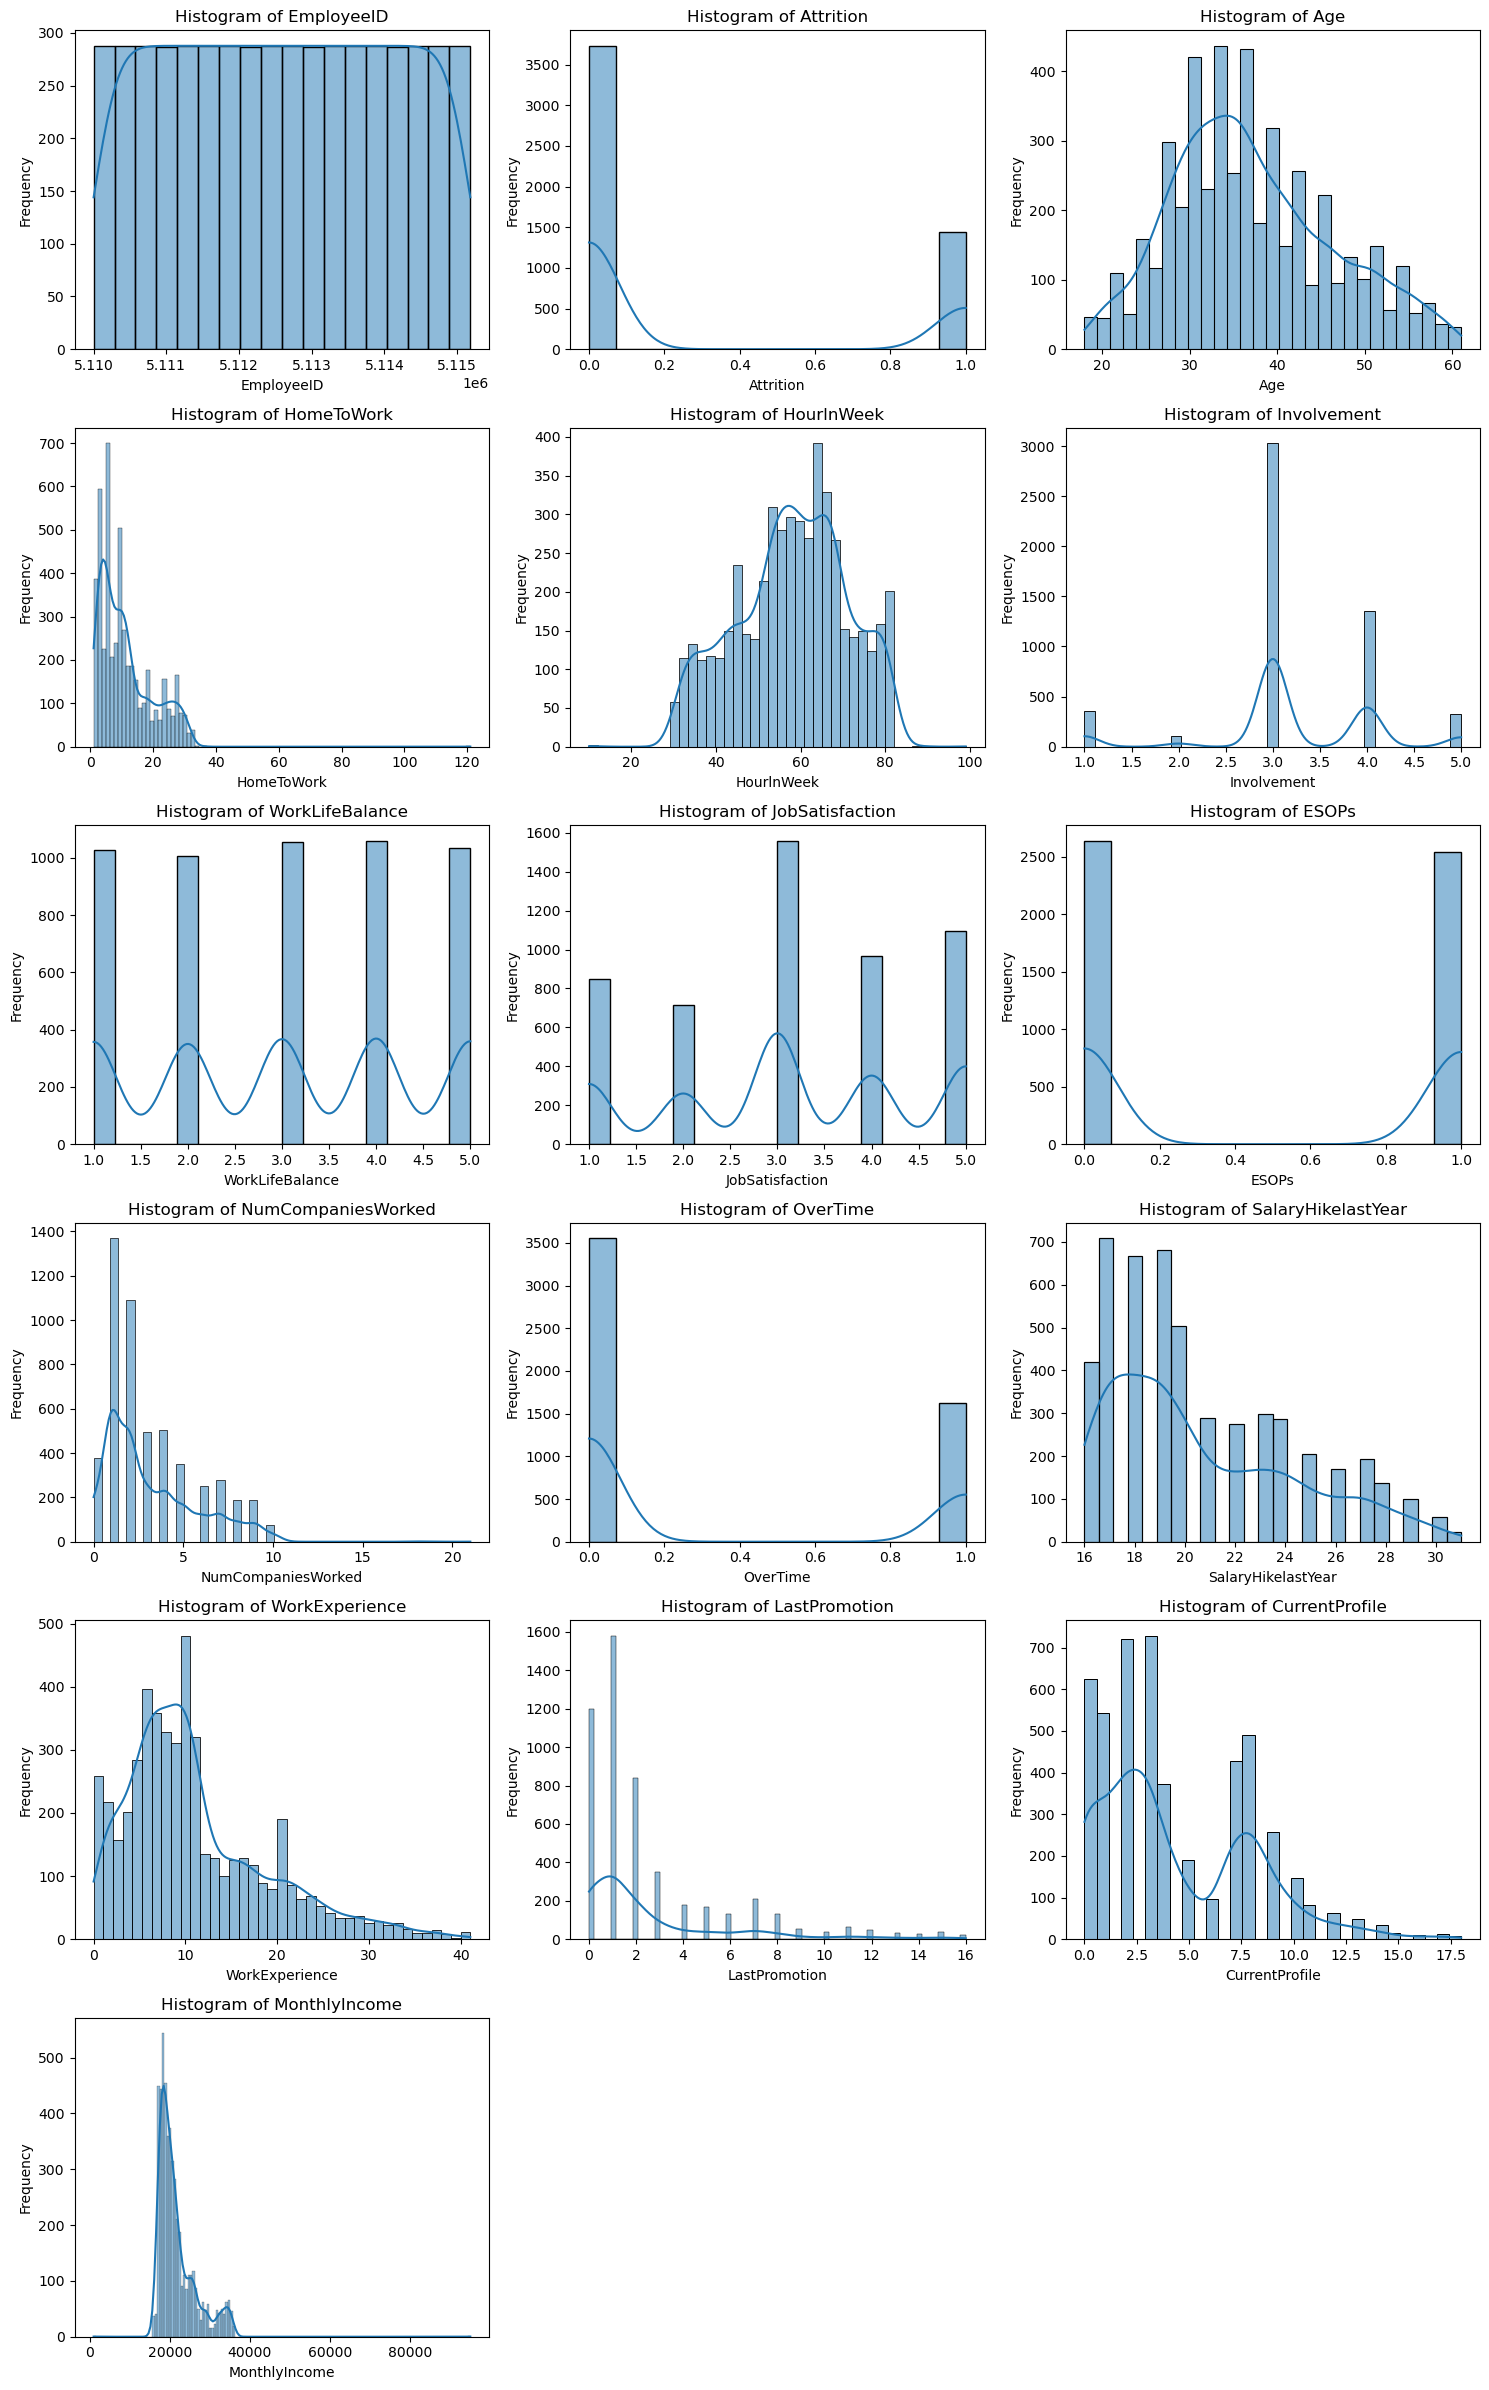

In [5]:
num_columns = train_data.select_dtypes(include='number').columns

n_cols = 3 
n_rows = (len(num_columns) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

axes = axes.flatten()

for i, column in enumerate(num_columns):
    sns.histplot(train_data[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [6]:
train_data = train_data.drop_duplicates(keep="first")

train_data.fillna(train_data.median(numeric_only=True), inplace=True)
test_data.fillna(test_data.median(numeric_only=True), inplace=True)

categorical_cols = train_data.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()

for col in categorical_cols:
    train_data[col] = label_encoder.fit_transform(train_data[col].astype(str))
    if col in test_data.columns:
        test_data[col] = label_encoder.transform(test_data[col].astype(str))

print("Basic clean-up complete.")

Basic clean-up complete.


In [7]:
X = train_data.drop(columns=['EmployeeID', 'Attrition'])
y = train_data['Attrition']

scaler = StandardScaler()
yeo_johnson = PowerTransformer(method='yeo-johnson')

X = pd.DataFrame(yeo_johnson.fit_transform(X), columns=X.columns)
test_data_transformed = pd.DataFrame(yeo_johnson.transform(test_data.drop(columns=['EmployeeID'])),
                                     columns=test_data.drop(columns=['EmployeeID']).columns)
print("Data transformation complete.")

X = scaler.fit_transform(X)
test_data_scaled = scaler.transform(test_data_transformed)
print("Data scaling complete.")

Data transformation complete.
Data scaling complete.


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

param_grid = {
    'n_estimators': [93, 94, 95, 96, 97, 98],  # Number of boosting rounds (higher = more complex, risk of overfitting)
    'learning_rate': [0.15, 0.20, 0.25, 0.30],
    # Step size shrinkage (lower = slower learning, higher = risk of overfitting)
    'max_depth': [7, 10, 15, 20],  # Maximum depth of each tree (higher = more complex model)
    'min_child_weight': [1.5, 1.55, 1.6, 1.65, 1.7],
    # Minimum sum of instance weight in a child node (higher = less complex)
    'subsample': [0.85, 0.9, 0.95, 1.0],  # Fraction of samples used per boosting round (higher = more data per tree)
    'colsample_bytree': [0.55, 0.56, 0.57, 0.58, 0.6],
    # Fraction of features used per tree (lower = more regularisation)
    'gamma': [0, 0.05, 0.08, 0.1, 0.25],
    # Minimum loss reduction required for a split (higher = more conservative splits)
    'reg_alpha': [0, 0.005, 0.008, 0.01, 0.012, 0.015],
    # L1 regularisation (helps reduce model complexity and overfitting)
    'reg_lambda': [0.5, 0.8, 1, 1.05, 1.1, 1.5],
    # L2 regularisation (also helps reduce complexity, controls weight size)
    'scale_pos_weight': [1, 2, 5, 10],
    # Balances classes by scaling positive instances (useful for imbalanced datasets)
    'max_delta_step': [0, 1, 2, 5],  # Maximum step for weights (useful for class imbalance, improves stability)
    'colsample_bylevel': [0.8, 0.9, 1.0],  # Fraction of features used per tree level (higher = more complex model)
    'colsample_bynode': [0.8, 0.9, 1.0],  # Fraction of features used per tree node (higher = more complex)
}

xgb_model = xgb.XGBClassifier(eval_metric='logloss')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_grid,
                                   n_iter=30,
                                   scoring='accuracy',
                                   cv=cv,
                                   n_jobs=-1,
                                   verbose=1,
                                   random_state=0)

random_search.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)
print("Model building complete.")

best_xgb_model = random_search.best_estimator_
best_hyperparameters = random_search.best_params_
print(f"Best hyperparameters: {best_hyperparameters}")

y_val_pred_xgb = best_xgb_model.predict(X_val)

val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
print(f'Validation Accuracy: {val_accuracy_xgb}')

test_predictions_xgb = best_xgb_model.predict(test_data_scaled)

submission_df_xgb = pd.DataFrame({
    'EmployeeID': test_data['EmployeeID'],
    'Attrition': test_predictions_xgb
})

cm = confusion_matrix(y_val, y_val_pred_xgb)
confusion_accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
print(f"Confusion Accuracy: {confusion_accuracy}")

kappa = cohen_kappa_score(y_val, y_val_pred_xgb)
print(f"Cohen Kappa Score: {kappa}")

jaccard = jaccard_score(y_val, y_val_pred_xgb)
print(f"Jaccard Score: {jaccard}")

submission_file_path_xgb = ('../d. Output Files/EmployeeAttrition/' + 'EmployeeAttrition_' + str(val_accuracy_xgb)[2:8] + '.csv')
print(f"File name: {submission_file_path_xgb.split('/')[3]}")
submission_df_xgb.to_csv(submission_file_path_xgb, index=False)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Model building complete.
Best hyperparameters: {'subsample': 1.0, 'scale_pos_weight': 1, 'reg_lambda': 1.1, 'reg_alpha': 0.008, 'n_estimators': 96, 'min_child_weight': 1.6, 'max_depth': 20, 'max_delta_step': 1, 'learning_rate': 0.2, 'gamma': 0.05, 'colsample_bytree': 0.56, 'colsample_bynode': 0.8, 'colsample_bylevel': 1.0}
Validation Accuracy: 0.9864995178399228
Confusion Accuracy: 0.9864995178399228
Cohen Kappa Score: 0.9666315774957365
Jaccard Score: 0.9531772575250836
File name: EmployeeAttrition_986499.csv
